#### Paleo Analysis and Parsing of the Paleontological Database
Data extracted from *The Paleobiology Database*															


In [28]:
# library imports
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import requests as rq
import io

In [29]:
# Scraping data from the Paleobiology Database and cleaning up the Null values
url = rq.get('https://paleobiodb.org/data1.2/occs/taxa.csv?base_name=dinosauria&rank=max_genus&taxon_status=accepted&pres=regular&max_ma=252&min_ma=65&show=parent,app,size,class').content
dinos = pd.read_csv(io.StringIO(url.decode('utf-8'))).drop(columns=['extant_size', 'orig_no', 'taxon_no', 'parent_no', 'record_type', 'flags', 'difference', 'accepted_no', 'accepted_rank', 'accepted_name', 'container_no', 'reference_no', 'is_extant', 'phylum', 'type_taxon', 'firstapp_min_ma', 'lastapp_max_ma'])

dinos.columns = ['Rank', 'Name', 'Parent Taxon', 'Number of Occurrences', 'First Appearance (MYA)', 'Last Appearance (MYA)', 'Early Interval', 'Late Interval', 'Taxon Size', 'Class', 'Order', 'Family', 'Genus']
dinos = dinos[['Name', 'Rank', 'Genus', 'Parent Taxon', 'Family', 'Order', 'Class', 'Number of Occurrences', 'Taxon Size', 'First Appearance (MYA)', 'Last Appearance (MYA)', 'Early Interval', 'Late Interval']]
dinos['Late Interval'] = dinos['Late Interval'].fillna(dinos['Early Interval'])

conditions = [
    (dinos['First Appearance (MYA)'] <= 251.9) & (dinos['Last Appearance (MYA)'] > 201.4), 
    (dinos['First Appearance (MYA)'] <= 201.4) & (dinos['Last Appearance (MYA)'] > 145.0),
    (dinos['First Appearance (MYA)'] <= 145.0) & (dinos['Last Appearance (MYA)'] > 66.0)
]

eras = ['Triassic', 'Jurassic', 'Cretaceous']

dinos['Era'] = np.select(conditions, eras, default=pd.NaT) #--> Need to fix the type errors here
dinos.head()

,Name,Rank,Genus,Parent Taxon,Family,Order,Class,Number of Occurrences,Taxon Size,First Appearance (MYA),Last Appearance (MYA),Early Interval,Late Interval,Era
0,Ajkaceratops,genus,Ajkaceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,2,2,86.3,83.6,Santonian,Santonian,Cretaceous
1,Ajkaceratops kozmai,species,Ajkaceratops,Ajkaceratops,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,1,1,86.3,83.6,Santonian,Santonian,Cretaceous
2,Turanoceratops,genus,Turanoceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,12,2,93.9,89.8,Turonian,Turonian,Cretaceous
3,Turanoceratops tardabilis,species,Turanoceratops,Turanoceratops,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,6,1,93.9,89.8,Turonian,Turonian,Cretaceous
4,Zuniceratops,genus,Zuniceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,6,2,93.9,89.8,Turonian,Turonian,Cretaceous


Here we are cleaning up the data to match the Michael Benton classification of Dinosauria

In [30]:
# Splitting the Genus up from the Species to separate the Parent Taxon column (need to include that in the species dataframe)
genus = dinos[dinos["Rank"] == 'genus'].drop(columns=['Rank'])
genus.tail()


,Name,Genus,Parent Taxon,Family,Order,Class,Number of Occurrences,Taxon Size,First Appearance (MYA),Last Appearance (MYA),Early Interval,Late Interval,Era
3002,Shuangbaisaurus,Shuangbaisaurus,Theropoda,NO_FAMILY_SPECIFIED,Theropoda,Reptilia,2,2,201.4,199.5,Hettangian,Hettangian,Jurassic
3004,Sinosaurus,Sinosaurus,Theropoda,NO_FAMILY_SPECIFIED,Theropoda,Reptilia,28,2,201.4,192.9,Hettangian,Sinemurian,Jurassic
3006,Tawa,Tawa,Theropoda,NO_FAMILY_SPECIFIED,Theropoda,Reptilia,6,2,227.0,208.5,Norian,Norian,Triassic
3008,Yaverlandia,Yaverlandia,Theropoda,NO_FAMILY_SPECIFIED,Theropoda,Reptilia,2,2,132.6,121.4,Hauterivian,Barremian,Cretaceous
3010,Nyasasaurus,Nyasasaurus,Dinosauria,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Reptilia,2,3,247.2,242.0,Anisian,Anisian,Triassic


In [31]:
# Creating the Species Dataframe to include the genus and parent taxon columns (this will be the main datafram we use)
species = dinos[dinos["Rank"] == 'species'].drop(columns=['Taxon Size', 'Rank', 'Parent Taxon'])
species = species.merge(genus[['Genus', 'Parent Taxon']], how='inner', on='Genus')[['Name', 'Genus', 'Parent Taxon', 'Family', 'Order', 'Class', 'Number of Occurrences', 'First Appearance (MYA)', 'Last Appearance (MYA)', 'Early Interval', 'Late Interval', 'Era']]
species.to_csv('dinosauria.csv', index=False)
species.head()

,Name,Genus,Parent Taxon,Family,Order,Class,Number of Occurrences,First Appearance (MYA),Last Appearance (MYA),Early Interval,Late Interval,Era
0,Ajkaceratops kozmai,Ajkaceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,1,86.3,83.6,Santonian,Santonian,Cretaceous
1,Turanoceratops tardabilis,Turanoceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,6,93.9,89.8,Turonian,Turonian,Cretaceous
2,Zuniceratops christopheri,Zuniceratops,Ceratopsoidea,NO_FAMILY_SPECIFIED,NO_ORDER_SPECIFIED,Ornithischia,3,93.9,89.8,Turonian,Turonian,Cretaceous
3,Bagaceratops rozhdestvenskyi,Bagaceratops,Protoceratopsidae,Protoceratopsidae,NO_ORDER_SPECIFIED,Ornithischia,4,83.6,72.1,Campanian,Campanian,Cretaceous
4,Breviceratops kozlowskii,Breviceratops,Protoceratopsidae,Protoceratopsidae,NO_ORDER_SPECIFIED,Ornithischia,2,83.6,72.1,Campanian,Campanian,Cretaceous


In [32]:
# Need to 

<Axes: xlabel='Era', ylabel='Count'>

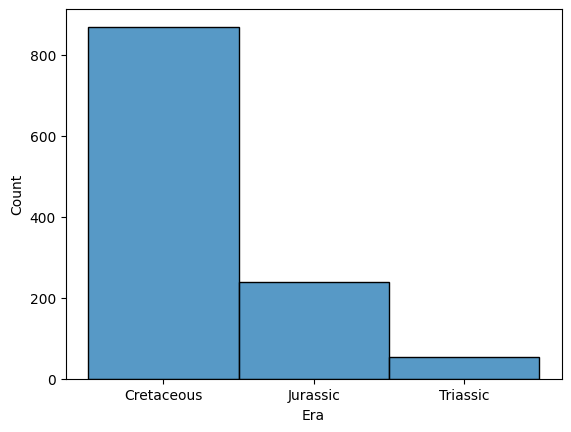

In [33]:
sb.histplot(data=species, x='Era')